# Librerias

In [1]:
%%capture 
!pip install transformers

In [2]:
from sklearn.model_selection import train_test_split
import torch

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%capture
!pip install wandb
import wandb
wandb.login()
# api key 64d2528e8d76865170c16bf804e7172bb3780c79

In [5]:
wandb.login()

True

In [6]:
!nvidia-smi

Mon Apr 19 07:46:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   56C    P0    56W / 149W |   1846MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

In [7]:
import torch
torch.cuda.empty_cache()

# Carga de datos
- incluidas nuevas columnas con concatenacion de review_body y categoria, review_body y titulo
- nuevos indices para star rating, de 0-4 en vez de 1-5
- numericalizar las categorias de los productos, 31 en total

In [8]:
# Load data
import pandas as pd## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

path1 = "amazonEN_train.csv"
path2 = "amazonEN_valid.csv"
path3 = "amazonEN_test.csv"
df_train = pd.read_csv(path1)
df_train = df_train
df_valid = pd.read_csv(path2)
df_valid = df_valid
df_test = pd.read_csv(path3)
df_test = df_test

In [9]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0953486,product_en_0381770,reviewer_en_0978532,4,"Great, great batteries. Arrived on time and pa...",Strip of 10 Fresh Maxell LR1130 Batteries,en,electronics,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,"Great, great batteries. Arrived on time and pa...",9


# Carga modelo BERT // distilBERT
- incluye tokenizer

In [10]:
# Bert 

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
from transformers import BertModel, BertConfig, BertTokenizer
from transformers import BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
# DistilBert

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


# BertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body

In [11]:
%env WANDB_PROJECT = RATING CLASSIFICATION BERT

env: WANDB_PROJECT=RATING CLASSIFICATION BERT


In [12]:
RANDOM_SEED=8
MAX_LENGTH=512


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 

In [13]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [14]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [16]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [25]:
from transformers import BertForSequenceClassification
from transformers import DistilBertForSequenceClassification

## DEFINIMOS EL MODELO 

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
device

device(type='cuda', index=0)

## Training

In [28]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [29]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    #report_to = 'wandb',
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                                 # total number of training epochs
    per_device_train_batch_size=8,                      # batch size per device during training
    per_device_eval_batch_size=16,                      # batch size for evaluation
    warmup_steps=500,                                   # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                  # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',          # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'review_body_vm',     
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset
    eval_dataset = val_data,              # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.847400,0.983318,0.575200,0.582777,0.602769,0.575200,95.262000,26.243000
2,0.794700,0.951746,0.581600,0.579192,0.583168,0.581600,95.661700,26.134000
3,0.689800,1.021605,0.585200,0.587599,0.591469,0.585200,95.439300,26.195000


TrainOutput(global_step=37500, training_loss=0.8406153692499797, metrics={'train_runtime': 72890.5877, 'train_samples_per_second': 0.514, 'total_flos': 2.01804751872e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 8192, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 228093952, 'train_mem_gpu_alloc_delta': 1840302592, 'train_mem_cpu_peaked_delta': 246857728, 'train_mem_gpu_peaked_delta': 6043361280})

## Evaluation

In [30]:
trainer.evaluate()

{'eval_loss': 1.0216052532196045,
 'eval_accuracy': 0.5852,
 'eval_f1': 0.5875991225638202,
 'eval_precision': 0.5914692585317319,
 'eval_recall': 0.5852,
 'eval_runtime': 95.5072,
 'eval_samples_per_second': 26.176,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 36864,
 'eval_mem_gpu_peaked_delta': 579257344}

##Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [31]:
# saving the fine tuned model & tokenizer
model_path = "Bert_body"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Bert_body/tokenizer_config.json',
 'Bert_body/special_tokens_map.json',
 'Bert_body/vocab.txt',
 'Bert_body/added_tokens.json')

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       480
           1       0.50      0.52      0.51       530
           2       0.51      0.49      0.50       501
           3       0.58      0.56      0.57       479
           4       0.75      0.78      0.76       510

    accuracy                           0.60      2500
   macro avg       0.60      0.60      0.60      2500
weighted avg       0.60      0.60      0.60      2500

{'test_loss': 0.9931801557540894, 'test_accuracy': 0.6032, 'test_f1': 0.6019477601297686, 'test_precision': 0.6011572089005479, 'test_recall': 0.6032, 'test_runtime': 94.9734, 'test_samples_per_second': 26.323, 'test_mem_cpu_alloc_delta': 983040, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 579257344}


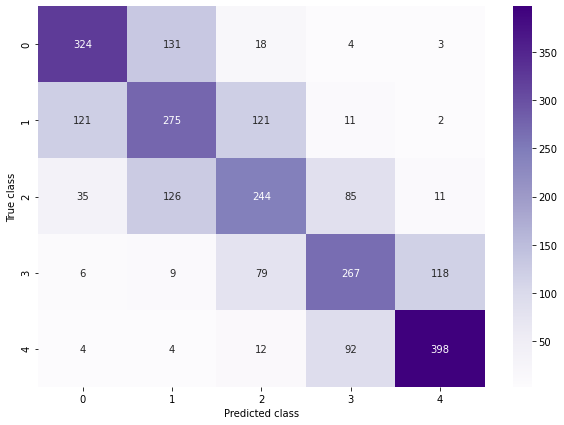

In [32]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

# BertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body + titulo

In [12]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 
#class_names = ['0','1'] 
#class_names = ['1']

In [13]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [14]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [16]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [17]:
## Lo definimos de nuevo unicamente con el proposito de usar las secciones del documento de forma independiente 

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
!nvidia-smi

In [20]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                                  # total number of training epochs
    per_device_train_batch_size=16,                       # batch size per device during training
    per_device_eval_batch_size=16,                       # batch size for evaluation
    warmup_steps=500,                                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                   # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'review_title + review_body', 
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset
    eval_dataset = val_data,              # evaluation dataset
    compute_metrics = compute_metrics             
)

trainer.train()

wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.745000,0.802589,0.642400,0.644819,0.662225,0.642400,49.473900,50.532000
2,0.716300,0.813697,0.650400,0.648424,0.652538,0.650400,49.404800,50.602000
3,0.537600,0.886456,0.647200,0.648297,0.650304,0.647200,49.364500,50.644000


TrainOutput(global_step=18750, training_loss=0.707719492594401, metrics={'train_runtime': 32351.7656, 'train_samples_per_second': 0.58, 'total_flos': 1.0247897556e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 876023808, 'train_mem_gpu_alloc_delta': 1794231808, 'train_mem_cpu_peaked_delta': 437395456, 'train_mem_gpu_peaked_delta': 4211624448})

## Evaluation

In [21]:
trainer.evaluate()

{'eval_loss': 0.813697338104248,
 'eval_accuracy': 0.6504,
 'eval_f1': 0.6484235248149245,
 'eval_precision': 0.6525380603461889,
 'eval_recall': 0.6504,
 'eval_runtime': 49.3432,
 'eval_samples_per_second': 50.666,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': -95944704,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 95944704,
 'eval_mem_gpu_peaked_delta': 194580480}

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       480
           1       0.65      0.51      0.57       530
           2       0.57      0.62      0.60       501
           3       0.65      0.59      0.62       479
           4       0.77      0.80      0.79       510

    accuracy                           0.66      2500
   macro avg       0.66      0.67      0.66      2500
weighted avg       0.66      0.66      0.66      2500

{'test_loss': 0.7946434617042542, 'test_accuracy': 0.6648, 'test_f1': 0.6610685741293841, 'test_precision': 0.6645006476402061, 'test_recall': 0.6648, 'test_runtime': 49.4844, 'test_samples_per_second': 50.521, 'test_mem_cpu_alloc_delta': 0, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 36864, 'test_mem_gpu_peaked_delta': 194580480}


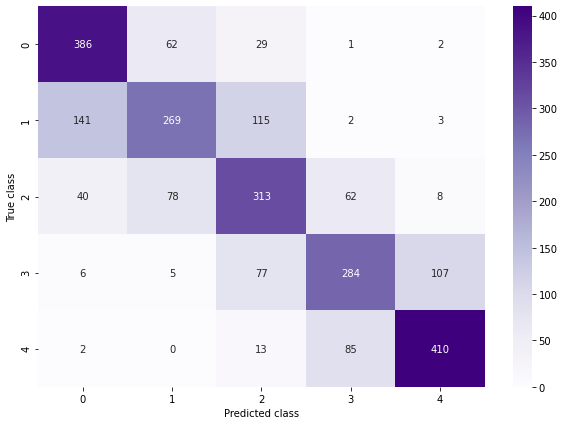

In [22]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [23]:
# saving the fine tuned model & tokenizer
model_path = "BERT_text_title"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('BERT_text_title/tokenizer_config.json',
 'BERT_text_title/special_tokens_map.json',
 'BERT_text_title/vocab.txt',
 'BERT_text_title/added_tokens.json')

# BertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body + titulo + categoria

In [12]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 
#class_names = ['0','1'] 
#class_names = ['1']

In [13]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [14]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [16]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [17]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [20]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                         # total number of training epochs
    per_device_train_batch_size=16,              # batch size per device during training
    per_device_eval_batch_size=64,              # batch size for evaluation
    warmup_steps=500,                           # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                          # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',   # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'review_title + review_body + category', 
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset
    eval_dataset = val_data,              # evaluation dataset
    compute_metrics = compute_metrics       
)

trainer.train()

wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.751400,0.815784,0.648000,0.651178,0.670135,0.648000,43.846700,57.017000
2,0.712800,0.808689,0.662000,0.660106,0.664421,0.662000,43.816600,57.056000
3,0.539000,0.889048,0.646400,0.647658,0.650033,0.646400,43.807900,57.067000


TrainOutput(global_step=18750, training_loss=0.7112088802337646, metrics={'train_runtime': 32407.5154, 'train_samples_per_second': 0.579, 'total_flos': 1.0247897556e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1017815040, 'train_mem_gpu_alloc_delta': 1794231808, 'train_mem_cpu_peaked_delta': 295903232, 'train_mem_gpu_peaked_delta': 4211624448})

## Evaluation

In [21]:
trainer.evaluate()

{'eval_loss': 0.8086891770362854,
 'eval_accuracy': 0.662,
 'eval_f1': 0.6601057838310194,
 'eval_precision': 0.6644205751905636,
 'eval_recall': 0.662,
 'eval_runtime': 43.3765,
 'eval_samples_per_second': 57.635,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 36864,
 'eval_mem_gpu_peaked_delta': 773972480}

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       480
           1       0.64      0.50      0.56       530
           2       0.58      0.62      0.60       501
           3       0.65      0.61      0.63       479
           4       0.77      0.80      0.79       510

    accuracy                           0.66      2500
   macro avg       0.66      0.66      0.66      2500
weighted avg       0.66      0.66      0.66      2500

{'test_loss': 0.7951874136924744, 'test_accuracy': 0.6608, 'test_f1': 0.6571152580443225, 'test_precision': 0.6600492612159862, 'test_recall': 0.6608, 'test_runtime': 43.47, 'test_samples_per_second': 57.511, 'test_mem_cpu_alloc_delta': 0, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 773972480}


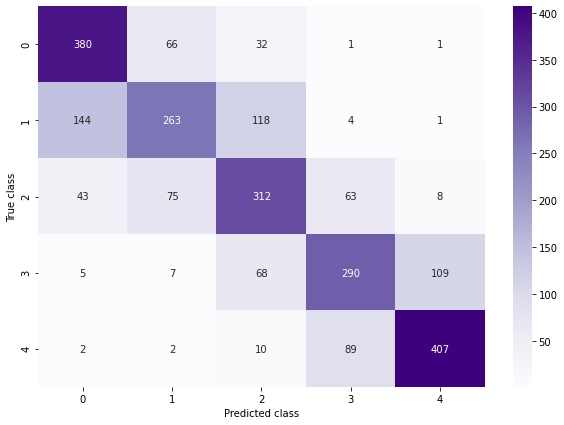

In [22]:
## Función test dato  BERT
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       480
           1       0.58      0.60      0.59       530
           2       0.60      0.52      0.55       501
           3       0.62      0.60      0.61       479
           4       0.77      0.80      0.78       510

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500

{'test_loss': 0.8567789196968079, 'test_accuracy': 0.6532, 'test_f1': 0.6508041912142799, 'test_precision': 0.6503822513602843, 'test_recall': 0.6532, 'test_runtime': 44.4951, 'test_samples_per_second': 56.186, 'test_mem_cpu_alloc_delta': 552960, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 2316416512}


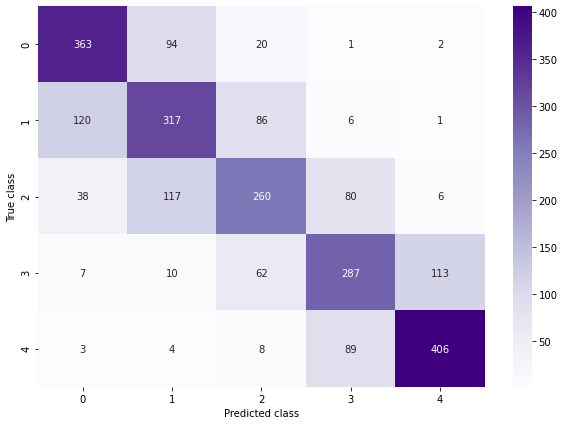

In [23]:
## Función test dato  distilBERT
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG/Modelos_entrenados/

Rating_text  Rating_text_title	Rating_text_title_cat


In [23]:
# saving the fine tuned model & tokenizer
model_path = "BERT_text_title_cat"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('BERT_text_title_cat/tokenizer_config.json',
 'BERT_text_title_cat/special_tokens_map.json',
 'BERT_text_title_cat/vocab.txt',
 'BERT_text_title_cat/added_tokens.json')

# BertForSequenceClassification - CATEGORÍA

- Clasificación de categorias de productos a partir del review_body

In [12]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = df_train.product_category.unique().tolist()

In [13]:
len(class_names)

31

In [14]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [15]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_labels = df_train.product_category_cod.values
val_labels = df_valid.product_category_cod.values
test_labels = df_test.product_category_cod.values

In [17]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [18]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [21]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [22]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                         # total number of training epochs
    per_device_train_batch_size=16,              # batch size per device during training
    per_device_eval_batch_size=64,              # batch size for evaluation
    warmup_steps=500,                           # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                          # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',   # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'review_body - CAT', 
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,         # training dataset
    eval_dataset = val_data,
    compute_metrics = compute_metrics            # evaluation dataset
)

trainer.train()

wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,1.546200,1.638183,0.524400,0.510363,0.525405,0.524400,43.617100,57.317000
2,1.355400,1.583955,0.540000,0.533469,0.540158,0.540000,43.681500,57.232000
3,1.288000,1.642287,0.540800,0.531086,0.531726,0.540800,43.758600,57.132000


TrainOutput(global_step=18750, training_loss=1.5085601072184245, metrics={'train_runtime': 32285.1138, 'train_samples_per_second': 0.581, 'total_flos': 1.02497689944e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 984928256, 'train_mem_gpu_alloc_delta': 1794471424, 'train_mem_cpu_peaked_delta': 340443136, 'train_mem_gpu_peaked_delta': 4211624448})

## Evaluation

In [23]:
trainer.evaluate()

{'eval_loss': 1.642287254333496,
 'eval_accuracy': 0.5408,
 'eval_f1': 0.5310858165403872,
 'eval_precision': 0.5317262544324995,
 'eval_recall': 0.5408,
 'eval_runtime': 43.7136,
 'eval_samples_per_second': 57.19,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 774225408}

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       192
           1       0.56      0.53      0.55       100
           2       0.41      0.40      0.41        35
           3       0.52      0.65      0.58       152
           4       0.64      0.59      0.62        54
           5       0.52      0.48      0.50        25
           6       0.86      0.83      0.85        84
           7       0.79      0.71      0.75        21
           8       0.45      0.48      0.47       143
           9       0.43      0.34      0.38        80
          10       0.50      0.61      0.55        31
          11       0.56      0.62      0.59        50
          12       0.39      0.48      0.43       208
          13       0.41      0.37      0.39        89
          14       0.00      0.00      0.00        29
          15       0.80      0.55      0.65        44
          16       0.52      0.67      0.59       128
          17       0.55    

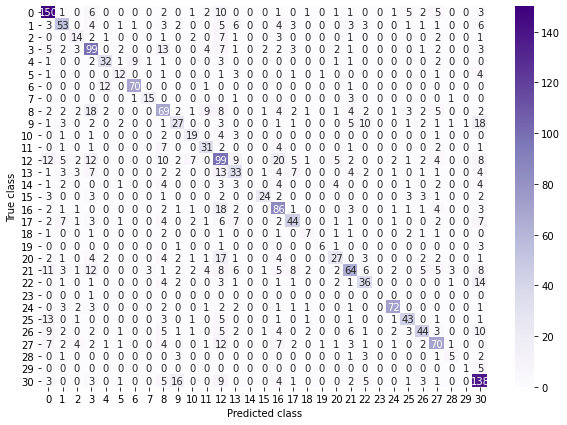

In [24]:
## Función test dato  distilBERT
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG/Modelos_entrenados/

Category_text	     Rating_text	Rating_text_title_cat
Category_text_title  Rating_text_title


In [25]:
# saving the fine tuned model & tokenizer
model_path = "BERT_body_CAT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('BERT_body_CAT/tokenizer_config.json',
 'BERT_body_CAT/special_tokens_map.json',
 'BERT_body_CAT/vocab.txt',
 'BERT_body_CAT/added_tokens.json')

# BertForSequenceClassification - CATEGORÍA

- Clasificación de categorias de productos a partir del review_body + titulo

In [12]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = df_train.product_category.unique().tolist()

In [13]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [14]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_labels = df_train.product_category_cod.values
val_labels = df_valid.product_category_cod.values
test_labels = df_test.product_category_cod.values

In [16]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [17]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [21]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                         # total number of training epochs
    per_device_train_batch_size=16,              # batch size per device during training
    per_device_eval_batch_size=64,              # batch size for evaluation
    warmup_steps=500,                           # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                          # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',   # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'review_body_title - CAT', 
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,         # training dataset
    eval_dataset = val_data,
    compute_metrics = compute_metrics             # evaluation dataset
)

trainer.train()

wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,1.434900,1.609875,0.530000,0.516687,0.525254,0.530000,43.758900,57.131000
2,1.348000,1.567031,0.549200,0.540452,0.544794,0.549200,43.598700,57.341000
3,1.220200,1.608695,0.559200,0.549338,0.547317,0.559200,43.786800,57.095000


TrainOutput(global_step=18750, training_loss=1.4605249835713705, metrics={'train_runtime': 32436.0798, 'train_samples_per_second': 0.578, 'total_flos': 1.02497689944e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 975134720, 'train_mem_gpu_alloc_delta': 1794471424, 'train_mem_cpu_peaked_delta': 340422656, 'train_mem_gpu_peaked_delta': 4211624448})

## Evaluation

In [23]:
trainer.evaluate()

{'eval_loss': 1.6086947917938232,
 'eval_accuracy': 0.5592,
 'eval_f1': 0.5493383401969347,
 'eval_precision': 0.5473174733762597,
 'eval_recall': 0.5592,
 'eval_runtime': 43.3493,
 'eval_samples_per_second': 57.671,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 774225408}

              precision    recall  f1-score   support

           0       0.63      0.80      0.70       192
           1       0.52      0.51      0.52       100
           2       0.46      0.49      0.47        35
           3       0.52      0.61      0.56       152
           4       0.67      0.59      0.63        54
           5       0.72      0.52      0.60        25
           6       0.89      0.87      0.88        84
           7       0.84      0.76      0.80        21
           8       0.51      0.50      0.51       143
           9       0.41      0.33      0.36        80
          10       0.54      0.61      0.58        31
          11       0.65      0.70      0.67        50
          12       0.44      0.52      0.47       208
          13       0.36      0.36      0.36        89
          14       0.00      0.00      0.00        29
          15       0.72      0.52      0.61        44
          16       0.55      0.66      0.60       128
          17       0.57    

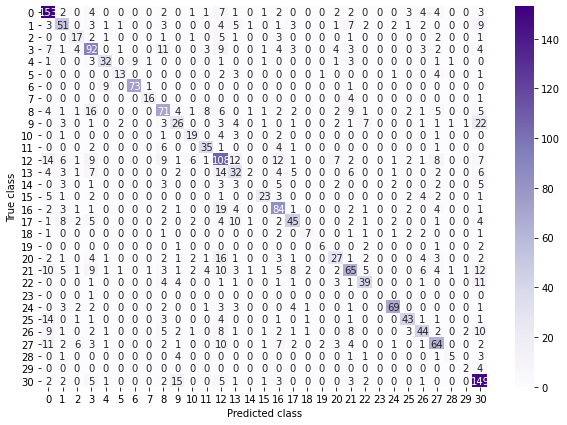

In [24]:
## Función test dato  distilBERT
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

ls: cannot access 'drive/MyDrive/TFG_1/Modelos_entrenados/': No such file or directory


In [22]:
# saving the fine tuned model & tokenizer
model_path = "BERT_text_title_CAT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('BERT_text_title_CAT/tokenizer_config.json',
 'BERT_text_title_CAT/special_tokens_map.json',
 'BERT_text_title_CAT/vocab.txt',
 'BERT_text_title_CAT/added_tokens.json')